# VAE with Pytorch
### Aim
The aim is to look to look at the latent variables, if they can capture biological age. The input are biomarkers of the NHANES3 cohort and age.

This version has a built in coxph...but it does not add that much to the model.
Option A vs. Option B (in the context of the prompt):
	•	Option A (Two-step approach): The VAE is trained independently of the CoxPH model. While this is simpler, it does not optimize the latent space z directly for the CoxPH model, which may lead to a latent space that is good for reconstructing x but suboptimal for predicting y.
	•	Option B (End-to-end approach): The VAE and CoxPH are trained together, ensuring that the latent variables z are jointly optimized for both reconstructing x and predicting y. This aligns more closely with the original instructions and is a more unified approach.

### Evaluation:
i) different number of latent variables
ii) mortality status (status), I made an AUC/ROC curve for logistic regression but maybe there is a better way?
iii) looking at the decoded output of age, although not as important as the first two

Let's try torch, the right py-kernel is python (myenv) and the env in conda is called ENVvae2, 
more details can be found in the meeting notes (Lukas May 3)
parameters to tweak: latent_dim and epochs

### Future work:
i) including status and see if it becomes better at predicting biological age
ii) parameter optimization / making the model better?
iii) other ways of evaluating?
iv) other ways of preprocessing the data/not preprocessing at all?

### Misc
The code is based on this tutorial: https://www.kaggle.com/code/schmiddey/variational-autoencoder-with-pytorch-vs-pca
It was difficult to find something for tabular data...

okay so since we have unbalanced classes we might have to consider that when doing logistic regression

for future me: I should save all output to a file so I don't have to do it manually.......

## Looking at the dataset

In [1]:
import torch
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.0.0


In [2]:
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import sklearn as sk

from lifelines import CoxPHFitter

In [4]:
import wandb
wandb. login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kixitrixi (kixi). Use `wandb login --relogin` to force relogin


True

In [5]:
# Initialize a new wandb run
wandb.init(project="VAE", name="VAE_coxph_wandb")


In [7]:
wandb.config = {
    "latent_dim": 2,
    "coxph_model": "lifelines",
    "optimizer": "None",
    # Add more parameters if necessary
}


In [8]:
# Inspecting the dataset...
df = pd.read_csv(r"/Users/karolinagustavsson/Code/Python_VAE/Data/NH3.csv")

print(df)

         sampleID  year  wave  gender  age  annual_income  income_recode  \
0          1991_3  1991     0       1   21            NaN            2.0   
1          1991_4  1991     0       2   32            NaN            8.0   
2          1991_9  1991     0       2   48            NaN            8.0   
3         1991_10  1991     0       1   35            NaN            8.0   
4         1991_11  1991     0       1   48            NaN            6.0   
...           ...   ...   ...     ...  ...            ...            ...   
18820  1991_53593  1991     0       1   23            NaN            6.0   
18821  1991_53594  1991     0       2   26            NaN            6.0   
18822  1991_53595  1991     0       1   32            NaN            5.0   
18823  1991_53616  1991     0       1   85            NaN            3.0   
18824  1991_53618  1991     0       2   79            NaN            2.0   

       education  edu  ethnicity  ...  status  ucod_leading  diabetes  \
0            3

## Preparing the data

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
from sklearn import preprocessing

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_data(path):
    # Load the dataset
    df = pd.read_csv(path)
    
    # Define the columns of interest
    columns_of_interest = ["sampleID", "status", "albumin", "alp", "lymph", "mcv",
                           "lncreat", "lncrp", "hba1c", "wbc", "rdw", "age"]
    ###VAFÖR inte ge den time? dock= hur ska den veta status 
    # Select only the necessary columns
    df = df[columns_of_interest]
    
    # Remove rows with any missing values
    df = df.dropna()

    # Separate out IDs and status, and keep them for later use
    ids = df['sampleID']
    status = df['status']
    ages = df['age'].values
    
    # Remove the ID and status columns from the dataframe to be normalized
    df_normalized = df.drop(['sampleID', 'status'], axis=1)
    
    # Normalize the data
    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(df_normalized)
    
    # Convert normalized data back into a DataFrame with appropriate column names
    df_normalized = pd.DataFrame(x_normalized, columns=df_normalized.columns)
    
    # Return the normalized data and scaler, along with IDs and status for reintegration later
    return df_normalized, scaler, ids, status, ages

# Example usage
DATA_PATH = '/Users/karolinagustavsson/Code/Python_VAE/Data/NH3.csv'
x_train, standardizer, train_ids, train_status, ages = load_data(DATA_PATH)


In [12]:
def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

In [13]:
###ADDEDCHUNK
from torch.utils.data import Dataset, DataLoader

class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.ids, self.status, self.time = load_data(path)  # Ensure load_data returns time and status
        # Convert data to tensors
        self.x = torch.tensor(self.x.values, dtype=torch.float32)  # x is a DataFrame, so we use .values
        self.time = torch.tensor(self.time, dtype=torch.float32)    # time is already a numpy array
        self.status = torch.tensor(self.status, dtype=torch.float32)  # status is already a numpy array
        self.len = self.x.shape[0]
        
        # Print shapes for debugging
        print("Shape of x:", self.x.shape)
        print("Shape of time:", self.time.shape)
        print("Shape of status:", self.status.shape)

    def __getitem__(self, index):
        return self.x[index], self.time[index], self.status[index]

    def __len__(self):
        return self.len

In [14]:
data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=1024, shuffle=False) ### Here we added shuffle false

Shape of x: torch.Size([15122, 10])
Shape of time: torch.Size([15122])
Shape of status: torch.Size([15122])


In [15]:
type(trainloader.dataset.x)

torch.Tensor

In [16]:
data_set.x

tensor([[ 1.4982,  0.2133,  0.3334,  ..., -0.2466, -0.8054, -1.3980],
        [-0.1006,  0.1032, -0.4331,  ...,  2.5606, -0.0608, -0.8349],
        [-0.3671, -0.9979, -0.0613,  ..., -1.0555, -1.1033, -0.0159],
        ...,
        [ 1.7647,  0.9106, -1.2798,  ...,  0.3006,  0.1378, -1.2956],
        [-0.3671, -0.5942,  1.5805,  ..., -0.9603,  0.8328, -1.1421],
        [ 0.4323,  1.9749, -0.1586,  ..., -0.2942,  0.5349,  1.8782]])

## Build model and train it

In [17]:
###ADDEDCHUNK
class CoxPHLoss(nn.Module):
    def __init__(self):
        super(CoxPHLoss, self).__init__()

    def forward(self, risks, time, status):
        """
        risks: Predicted risks from the model (one-dimensional tensor).
        time: Tensor indicating follow-up time for each patient.
        status: Binary tensor (1 if event occurred, 0 if censored).
        """
        # Get sorting indices for descending order of `time`
        sorted_indices = torch.argsort(time, descending=True)
        
        # Create temporarily sorted versions for calculations
        risks_sorted = risks[sorted_indices]
        status_sorted = status[sorted_indices]
        
        # Calculate hazard ratios and cumulative log hazard
        hazard_ratio = torch.exp(risks_sorted)
        log_cumulative_hazard = torch.log(torch.cumsum(hazard_ratio, dim=0))
        
        # Compute uncensored log-likelihood
        uncensored_likelihood = risks_sorted - log_cumulative_hazard
        censored_likelihood = uncensored_likelihood * status_sorted
        
        # Sum up the negative log-likelihood
        return -torch.sum(censored_likelihood)

In [146]:
###LETS SEE IF IT WORKS--ADDEDCHUNK version of chunk above
class Autoencoder(nn.Module):
    def __init__(self, D_in, H=50, H2=12, latent_dim=5):
        super(Autoencoder, self).__init__()
        # Define encoder layers
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        # Latent space
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Risk layer for CoxPH prediction
        self.risk_layer = nn.Linear(latent_dim, 1)  # Single output for risk prediction

        # Define decoder layers
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))
        fc1 = F.relu(self.bn1(self.fc1(lin3)))
        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))
        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x):
        # Encoding
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # Decoding
        recon_batch = self.decode(z)
        # Risk prediction for CoxPH
        risk = self.risk_layer(z).squeeze(-1)  # Ensure risk is a 1D tensor [batch_size]
        return recon_batch, mu, logvar, risk

In [147]:
###ADDEDCHUNK previously big c which is wrong should be lowercase
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        self.coxph_loss = CoxPHLoss()

    def forward(self, x_recon, x, mu, logvar, risk, events):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss_coxph = self.coxph_loss(risk, events)
        return loss_MSE + loss_KLD + loss_coxph * 2

In [148]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [149]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [150]:
loss_mse = customLoss()

In [151]:
### Train model
epochs = 15
log_interval = 50
val_losses = []
train_losses = []

In [152]:
#### Now with more detailed loss metrics
# Reinitialize the VAE model before running the training loop
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)  # Autoencoder model
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = customLoss()

###ADDEDCHUNK
def train(epoch):
    model.train()
    train_loss = 0
    total_reconstruction_loss = 0
    total_kl_loss = 0
    total_coxph_loss = 0

    for batch_idx, (data, time, status) in enumerate(trainloader):  # Unpack data, follow-up time, and status
        data, time, status = data.to(device), time.to(device), status.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar, risk = model(data)
        
        # Compute individual losses
        reconstruction_loss = loss_mse.mse_loss(recon_batch, data)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        coxph_loss = loss_mse.coxph_loss(risk, time, status)
        
        # Combine the losses
        loss = reconstruction_loss + kl_loss + coxph_loss
        loss.backward()
        optimizer.step()
        
        # Accumulate total losses
        train_loss += loss.item()
        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()
        total_coxph_loss += coxph_loss.item()

###ADDED CHUNK
    # Log average losses per epoch
    avg_total_loss = train_loss / len(trainloader.dataset)
    avg_reconstruction_loss = total_reconstruction_loss / len(trainloader.dataset)
    avg_kl_loss = total_kl_loss / len(trainloader.dataset)
    avg_coxph_loss = total_coxph_loss / len(trainloader.dataset)
    
    print(f'====> Epoch: {epoch} Average total loss: {avg_total_loss:.4f}')
    print(f'====> Epoch: {epoch} Average reconstruction loss: {avg_reconstruction_loss:.4f}')
    print(f'====> Epoch: {epoch} Average KL divergence: {avg_kl_loss:.4f}')
    print(f'====> Epoch: {epoch} Average CoxPH loss: {avg_coxph_loss:.4f}')

# Run training for multiple epochs
epochs = 15
for epoch in range(1, epochs + 1):
    train(epoch)


====> Epoch: 1 Average total loss: 20.4062
====> Epoch: 1 Average reconstruction loss: 18.5225
====> Epoch: 1 Average KL divergence: 0.7675
====> Epoch: 1 Average CoxPH loss: 1.1162
====> Epoch: 2 Average total loss: 18.3472
====> Epoch: 2 Average reconstruction loss: 16.4661
====> Epoch: 2 Average KL divergence: 0.7662
====> Epoch: 2 Average CoxPH loss: 1.1148
====> Epoch: 3 Average total loss: 17.1531
====> Epoch: 3 Average reconstruction loss: 15.1927
====> Epoch: 3 Average KL divergence: 0.8438
====> Epoch: 3 Average CoxPH loss: 1.1166
====> Epoch: 4 Average total loss: 16.4186
====> Epoch: 4 Average reconstruction loss: 14.3730
====> Epoch: 4 Average KL divergence: 0.9367
====> Epoch: 4 Average CoxPH loss: 1.1089
====> Epoch: 5 Average total loss: 15.8738
====> Epoch: 5 Average reconstruction loss: 13.7523
====> Epoch: 5 Average KL divergence: 1.0138
====> Epoch: 5 Average CoxPH loss: 1.1078
====> Epoch: 6 Average total loss: 15.3222
====> Epoch: 6 Average reconstruction loss: 13.

## Evaluate

In [153]:
###ADDED chunks
### Evaluate
standardizer = trainloader.dataset.standardizer

model.eval()
test_loss = 0
total_reconstruction_loss = 0
total_kl_loss = 0
total_coxph_loss = 0

# Collect latent variables and risk predictions
mu_output = []
logvar_output = []
risk_output = []
decoded_output = []

# no_grad() means we don't update the weights during evaluation
with torch.no_grad():
    for i, (data, time, status) in enumerate(trainloader):  # Adjust to include time and status
        data, time, status = data.to(device), time.to(device), status.to(device)
        
        # Forward pass
        recon_batch, mu, logvar, risk = model(data)
        
        # Calculate individual losses
        reconstruction_loss = loss_mse.mse_loss(recon_batch, data)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        coxph_loss = loss_mse.coxph_loss(risk, time, status)
        
        # Accumulate total losses
        test_loss += reconstruction_loss + kl_loss + coxph_loss
        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()
        total_coxph_loss += coxph_loss.item()
        
        # Collect outputs for inspection
        mu_output.append(mu.cpu().numpy())
        logvar_output.append(logvar.cpu().numpy())
        risk_output.append(risk.cpu().numpy())
        decoded_output.append(recon_batch.cpu().numpy())

# Average losses for evaluation metrics
avg_total_loss = test_loss / len(trainloader.dataset)
avg_reconstruction_loss = total_reconstruction_loss / len(trainloader.dataset)
avg_kl_loss = total_kl_loss / len(trainloader.dataset)
avg_coxph_loss = total_coxph_loss / len(trainloader.dataset)

print(f"Average total loss: {avg_total_loss:.4f}")
print(f"Average reconstruction loss: {avg_reconstruction_loss:.4f}")
print(f"Average KL divergence: {avg_kl_loss:.4f}")
print(f"Average CoxPH loss: {avg_coxph_loss:.4f}")

### Reverse scaling for reconstruction inspection
# Concatenate all decoded outputs and reverse the scaling
decoded_data = np.concatenate(decoded_output, axis=0)
original_decoded_data = standardizer.inverse_transform(decoded_data)

# If age is the last column, extract decoded ages
decoded_ages = original_decoded_data[:, -1]  # Adjust this if age is in a different column

### Concatenate all latent variables and risks
mu_result = np.concatenate(mu_output, axis=0)
logvar_result = np.concatenate(logvar_output, axis=0)
risk_result = np.concatenate(risk_output, axis=0)

# Inspect shapes and values if needed
print("Shape of mu_result:", mu_result.shape)
print("Sample mu_result:", mu_result[1:5, :])
print("Shape of risk_result:", risk_result.shape)
print("Sample risk_result:", risk_result[1:5])

Average total loss: 10.2332
Average reconstruction loss: 7.7223
Average KL divergence: 1.4399
Average CoxPH loss: 1.0710
Shape of mu_result: (15122, 5)
Sample mu_result: [[-0.18434152 -0.34144926 -0.5176519  -0.13767956 -0.20554474]
 [-0.3350647  -0.60383517 -0.84664875 -0.3012804  -0.18664044]
 [-0.51687914 -0.20973161 -0.50489753 -0.46014172  0.31963247]
 [ 0.5784996   0.7903051   0.05583887  0.5714028  -0.3689086 ]]
Shape of risk_result: (15122,)
Sample risk_result: [-0.043257   -0.0694815  -0.09783367 -0.06484751]


Latent Variable 1:
              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88     11883
         1.0       0.48      0.07      0.12      3239

    accuracy                           0.78     15122
   macro avg       0.64      0.52      0.50     15122
weighted avg       0.73      0.78      0.71     15122

AUC for Latent Variable 1: 0.7097

Latent Variable 2:
              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88     11883
         1.0       0.54      0.15      0.24      3239

    accuracy                           0.79     15122
   macro avg       0.67      0.56      0.56     15122
weighted avg       0.75      0.79      0.74     15122

AUC for Latent Variable 2: 0.7732

Latent Variable 3:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     11883
         1.0       0.00      0.00      0.00      3239

    accuracy                           0.79     15122
 

/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

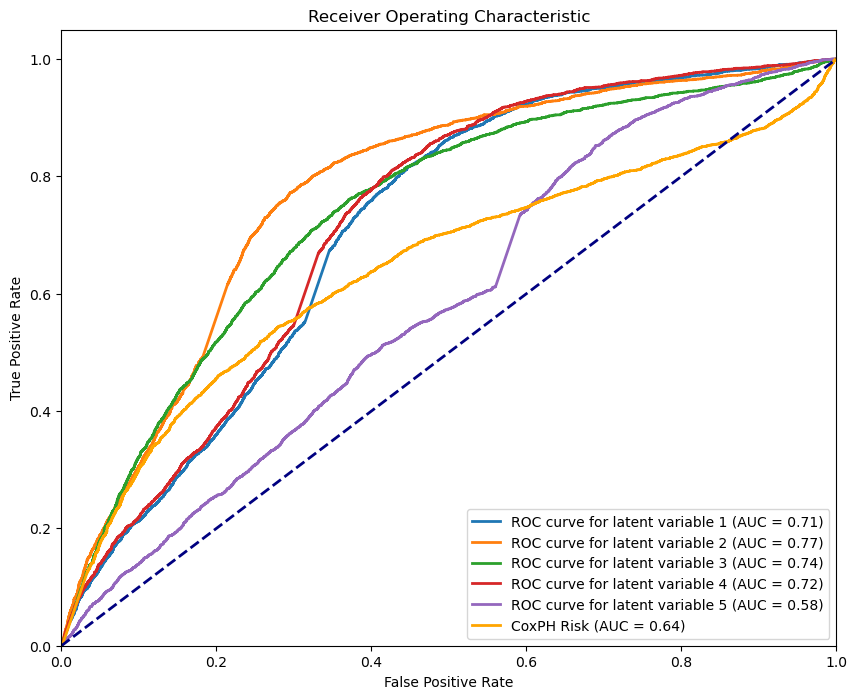

In [154]:
### ADDED CHUNK
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assuming mu_result, train_status, and risk_result are already defined
latent_dim = mu_result.shape[1]  # Get the number of latent dimensions

# Create a figure to hold the ROC plots
plt.figure(figsize=(10, 8))

# Loop over latent variables
for i in range(latent_dim):
    model = LogisticRegression()
    model.fit(mu_result[:, i:i+1], train_status)
    
    # Predict probabilities for the positive class
    probas_ = model.predict_proba(mu_result[:, i:i+1])[:, 1]
    
    # Compute ROC curve and area under the curve (AUC)
    fpr, tpr, thresholds = roc_curve(train_status, probas_)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for latent variable {i+1} (AUC = {roc_auc:.2f})')

    # Print classification report and AUC for each latent variable
    print(f'Latent Variable {i+1}:')
    print(classification_report(train_status, model.predict(mu_result[:, i:i+1])))
    print(f"AUC for Latent Variable {i+1}: {roc_auc_score(train_status, probas_):.4f}\n")

# Evaluate CoxPH risk predictions
fpr, tpr, thresholds = roc_curve(train_status, risk_result)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='orange', label=f'CoxPH Risk (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [155]:
for i in range(latent_dim):
    print(f"Variance of Latent Variable {i+1}: {np.var(mu_result[:, i])}")

Variance of Latent Variable 1: 0.33867117762565613
Variance of Latent Variable 2: 0.4692091643810272
Variance of Latent Variable 3: 0.5767707228660583
Variance of Latent Variable 4: 0.27856314182281494
Variance of Latent Variable 5: 0.3268788158893585


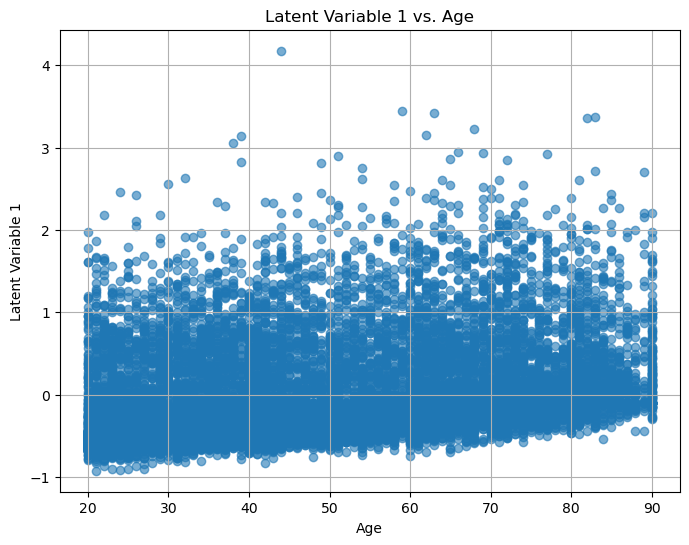

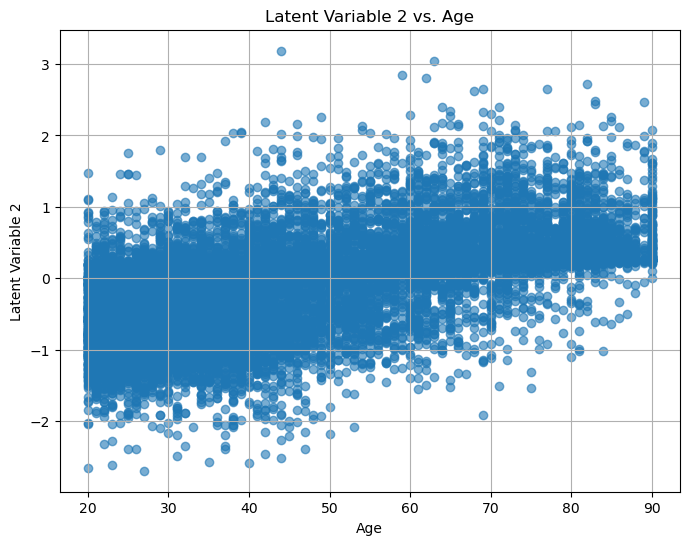

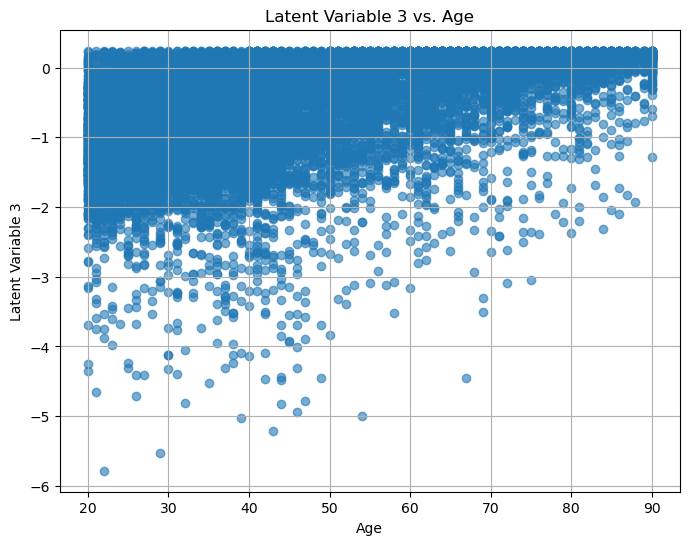

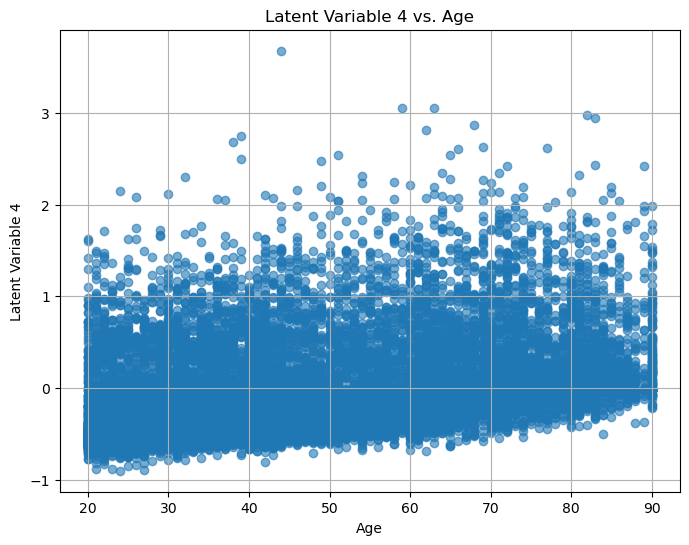

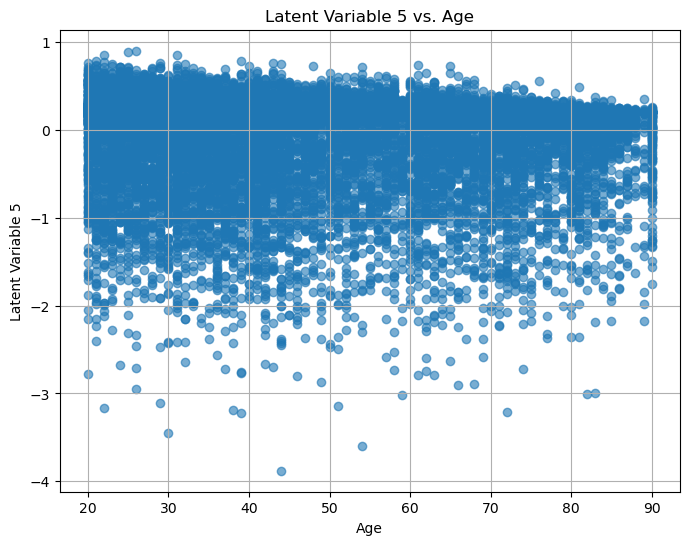

In [156]:
# Assuming mu_result is available and contains the latent variables for your data
latent_dim = mu_result.shape[1]  # Number of latent dimensions

for i in range(latent_dim):
    plt.figure(figsize=(8, 6))
    plt.scatter(ages, mu_result[:, i], alpha=0.6)
    plt.title(f'Latent Variable {i+1} vs. Age')
    plt.xlabel('Age')
    plt.ylabel(f'Latent Variable {i+1}')
    plt.grid(True)
    plt.show()

In [157]:
from scipy.stats import pearsonr

for i in range(latent_dim):
    correlation, _ = pearsonr(mu_result[:, i], ages)
    print(f'Correlation between Latent Variable {i+1} and Age: {correlation:.3f}')

Correlation between Latent Variable 1 and Age: 0.327
Correlation between Latent Variable 2 and Age: 0.582
Correlation between Latent Variable 3 and Age: 0.546
Correlation between Latent Variable 4 and Age: 0.374
Correlation between Latent Variable 5 and Age: -0.057


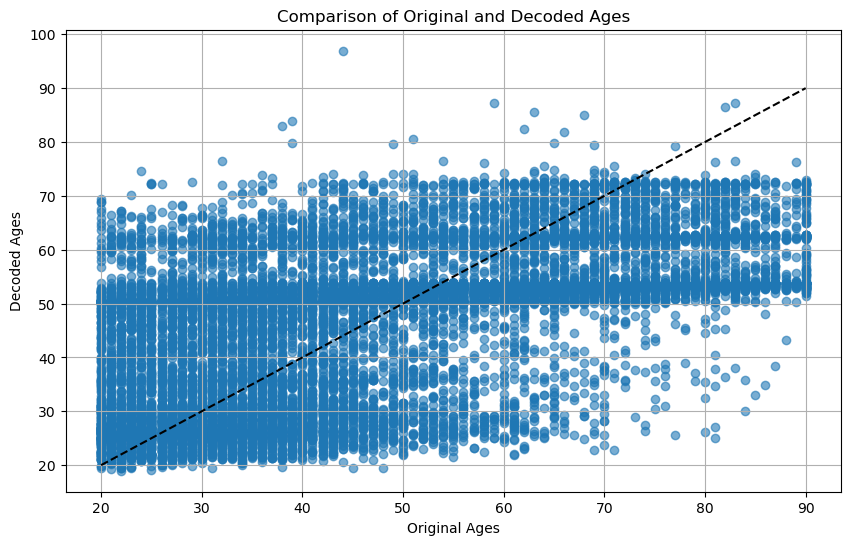

In [158]:
# Assuming `ages` is the array of original ages you extracted when loading the data
plt.figure(figsize=(10, 6))
plt.scatter(ages, decoded_ages, alpha=0.6)
plt.title('Comparison of Original and Decoded Ages')
plt.xlabel('Original Ages')
plt.ylabel('Decoded Ages')
plt.plot([ages.min(), ages.max()], [ages.min(), ages.max()], 'k--')  # Line showing perfect reconstruction
plt.grid(True)
plt.show()

Warning: /opt/homebrew/Caskroom/miniforge/base/envs/ENVvae2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Indicates: This indicates that for at least one class, there were no predicted samples, and as such, metrics like precision, recall, and F-score cannot be calculated (dividing by zero issue). By default, sklearn sets these metrics to 0.0 in such cases.

In [ ]:
wandb.finish()